# AKLT

In [1]:
# The C2QA package is currently not published to PyPI.
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import c2qa
import qiskit
import numpy as np
import scipy
import itertools
import c2qa.util as util
import c2qa.stateReadout as stateReadout
import matplotlib.pyplot as plt
# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
from collections import Counter

# Initialization

### Create a circuit with an even number of site modes and two memory qubits

In [8]:
numberofmodes=4

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes)
qbr = qiskit.QuantumRegister(size=3)
cbr = qiskit.ClassicalRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qbr, cbr)
# circuit = c2qa.CVCircuit(qmr)

### Initialize the oscillators to Fock state 1 (to get a zero spin-1 state in the Schwinger-Boson representation) and the qubit to a superposition

In [9]:
zeroQB=np.array([1,0]) #211012 agrees with Kevin's notation
oneQB=np.array([0,1]) #211012 agrees with Kevin's notation
two=np.array([0,0,1,0])
one=np.array([0,1,0,0])
zero=np.array([1,0,0,0])

# Choose initial state
qbinist=1
samestallmodes=1
diffstallmodes=[1,1]
# Initialize qubit
qubitinitialstate=[[zeroQB,"0"],[oneQB,"1"]]
circuit.initialize(qubitinitialstate[qbinist][0], qbr[0])

# Initialize both qumodes to a zero spin 1 state (Fock state 1)
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(samestallmodes, qmr[i]) #diffstallmodes[i] or samestallmodes
word="samestallmodes" #should correspond to the above line

In [6]:
# Testing gates using stateread

circuit.cv_bs(np.pi/4, qmr[1], qmr[0])
stateop, _ = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, 4)

qubits:  000  qumodes:  02     with amplitude:  -0.408248290463863
qubits:  000  qumodes:  11     with amplitude:  0.816496580927726
qubits:  000  qumodes:  20     with amplitude:  0.408248290463863


/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


## Circuit to create AKLT state

### Memory qubits and sites as Schwinger-Boson modes.
##### Full circuit

In [10]:
## Prepare the memory qubits in the singlet
circuit.x(qbr[0])
circuit.x(qbr[1])
circuit.h(qbr[0])
circuit.cnot(qbr[0],qbr[1])
circuit.barrier()
## Native gates circuit
for i in range(numberofmodes-1):
    if (i % 2) == 0:
        circuit.cv_bs(np.arctan(1/np.sqrt(2)), qmr[i+1], qmr[i])
        circuit.cv_snap(np.pi, 2, qmr[i + 1])
        circuit.cv_cp(np.pi,qmr[i],qbr[0])
        circuit.cv_bs(np.pi/4, qmr[i+1], qmr[i])
        circuit.x(qbr[0])
        circuit.cv_pncqr(-np.pi/2, 1, qmr[i],qbr[0], "Y")
        circuit.x(qbr[0])
        circuit.z(qbr[0])
        circuit.x(qbr[0])
        circuit.barrier()
## Do the SWAP test on the memory qubits to find out if they are in the singlet or the triplet
circuit.h(qbr[2])
circuit.cswap(qbr[2], qbr[0], qbr[1])
circuit.h(qbr[2])
circuit.measure(-1,0)
## Include the ancillas into the circuit dependent on their state
circuit.x(qbr[0]).c_if(cbr, 0)
circuit.x(qbr[1]).c_if(cbr, 0)
circuit.z(qbr[0]).c_if(cbr, 0)
circuit.z(qbr[1]).c_if(cbr, 0)
circuit.measure_all()

##### Partial circuit

In [10]:
numberofmodes=2
qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes)
qbr = qiskit.QuantumRegister(size=1)
cbr = qiskit.ClassicalRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qbr, cbr)
zeroQB = np.array([1, 0])  #211012 agrees with Kevin's notation
oneQB = np.array([0, 1])
one = np.array([0, 1, 0, 0])
qbinist = 0
samestallmodes = 1
qubitinitialstate = [[zeroQB, "0"], [oneQB, "1"]]
circuit.initialize(qubitinitialstate[qbinist][0], qbr[0])
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(samestallmodes, qmr[i])

for i in range(numberofmodes-1):
    if (i % 2) == 0:
        circuit.cv_bs(np.arctan(1/np.sqrt(2)), qmr[i+1], qmr[i])
        circuit.cv_snap(np.pi, 2, qmr[i + 1])
        circuit.cv_cp(qmr[i],qbr[0])
        circuit.cv_bs(np.pi/4, qmr[i+1], qmr[i])
        circuit.x(qbr[0])
        circuit.cv_pncqr(-np.pi/2, 1, qmr[i],qbr[0], "Y")
        circuit.x(qbr[0])
        circuit.z(qbr[0])
        circuit.x(qbr[0])

###### Simulate the partial circuit
with qbinist = 0 expect
qubits:  0  qumodes:  11     with amplitude:  0.577350269189626
qubits:  1  qumodes:  20     with amplitude:  0.8164965809277261
and qbinist = 1 expect
qubits:  0  qumodes:  02     with amplitude:  -0.8164965809277264
qubits:  1  qumodes:  11     with amplitude:  -0.577350269189626

In [11]:
stateop, _ = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, 4)

qumodes:  11  qubits:  0     with amplitude:  0.577350269189626
qumodes:  20  qubits:  1     with amplitude:  0.8164965809277261


### Memory modes and site qubits.
##### Partial circuit

In [49]:
numberofmodes=2
qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes)
qbr = qiskit.QuantumRegister(size=2)
circuit = c2qa.CVCircuit(qmr, qbr)
zeroQB = np.array([1, 0])
oneQB = np.array([0, 1])
qbinist = 0
diffstallmodes=[1, 0]
qubitinitialstate = [[zeroQB, "0"], [oneQB, "1"]]
for i in range(qbr.size):
    circuit.initialize(qubitinitialstate[qbinist][0], qbr[i])
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

circuit.cv_bs(np.pi/2, qmr[1], qmr[0])
circuit.cv_snap(np.pi, 1, qmr[1])
circuit.cv_pncqr(-np.arctan(1/np.sqrt(2))+(np.pi/2), 1, qmr[0],qbr[0], "Y")
circuit.cv_pncqr(-np.arctan(1/np.sqrt(2))+(np.pi/2), 1, qmr[1],qbr[1], "Y")
circuit.cv_cnd_bs(0, -np.pi, qbr[0], qmr[1], qmr[0])
circuit.cv_cnd_bs(0, np.pi, qbr[1], qmr[1], qmr[0])

stateop, _ = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, 4)

qumodes:  01  qubits:  00     with amplitude:  0.40824829046385935
qumodes:  10  qubits:  00     with amplitude:  0.40824829046385946
qumodes:  10  qubits:  01     with amplitude:  0.5773502691896238
qumodes:  01  qubits:  10     with amplitude:  0.5773502691896205


##### Print the circuit

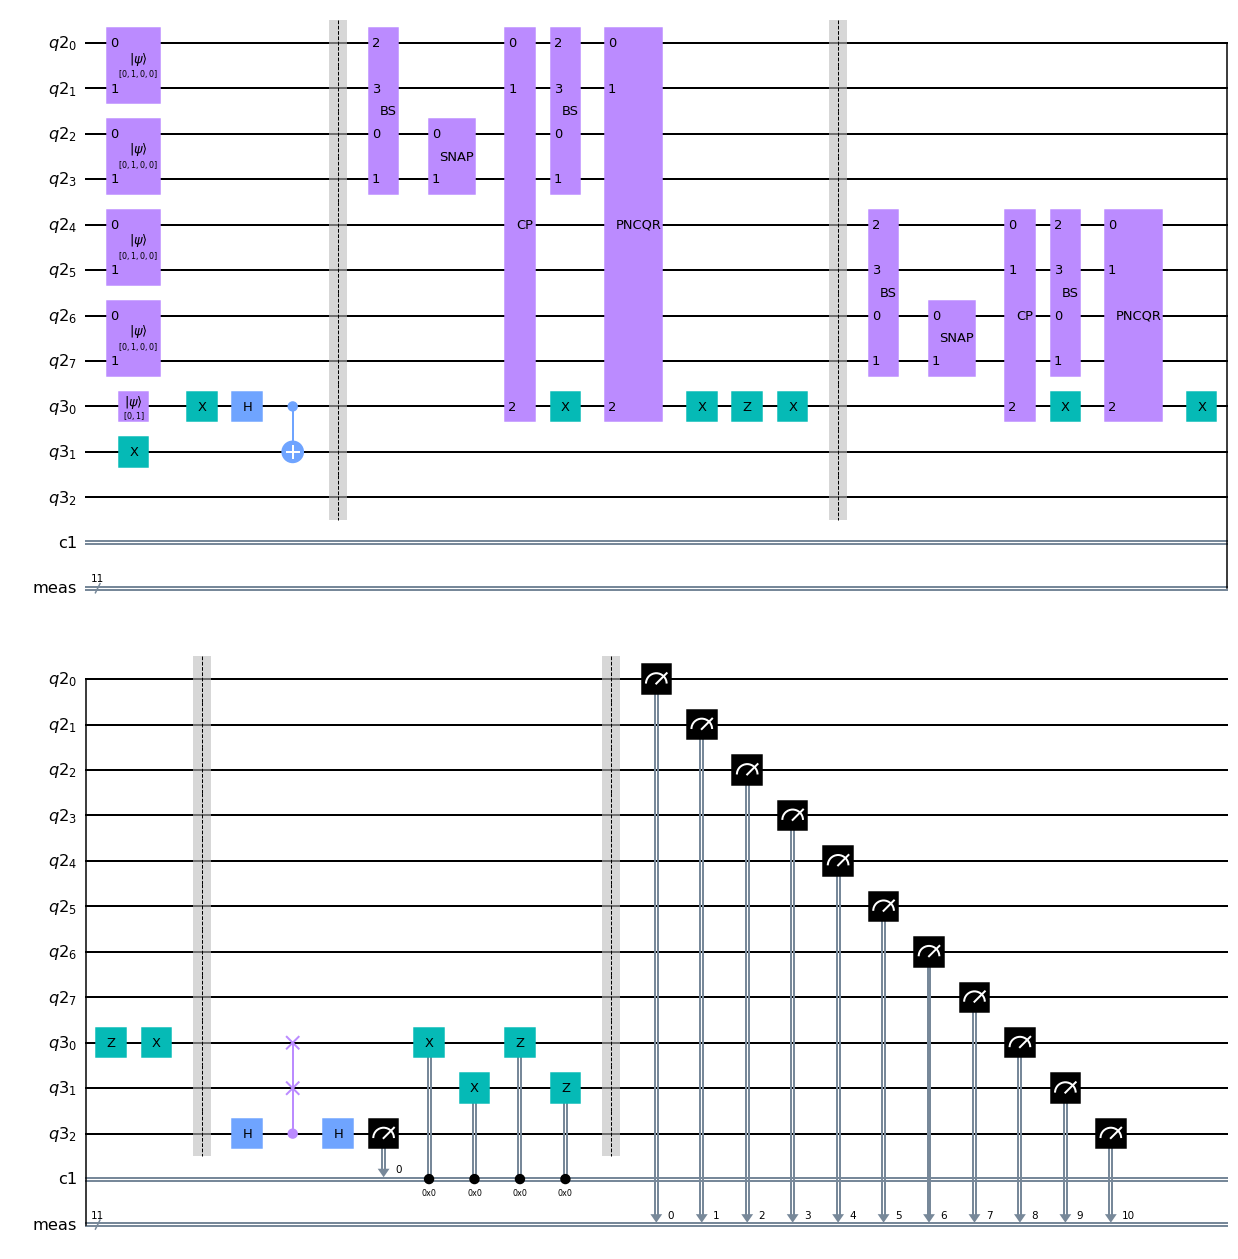

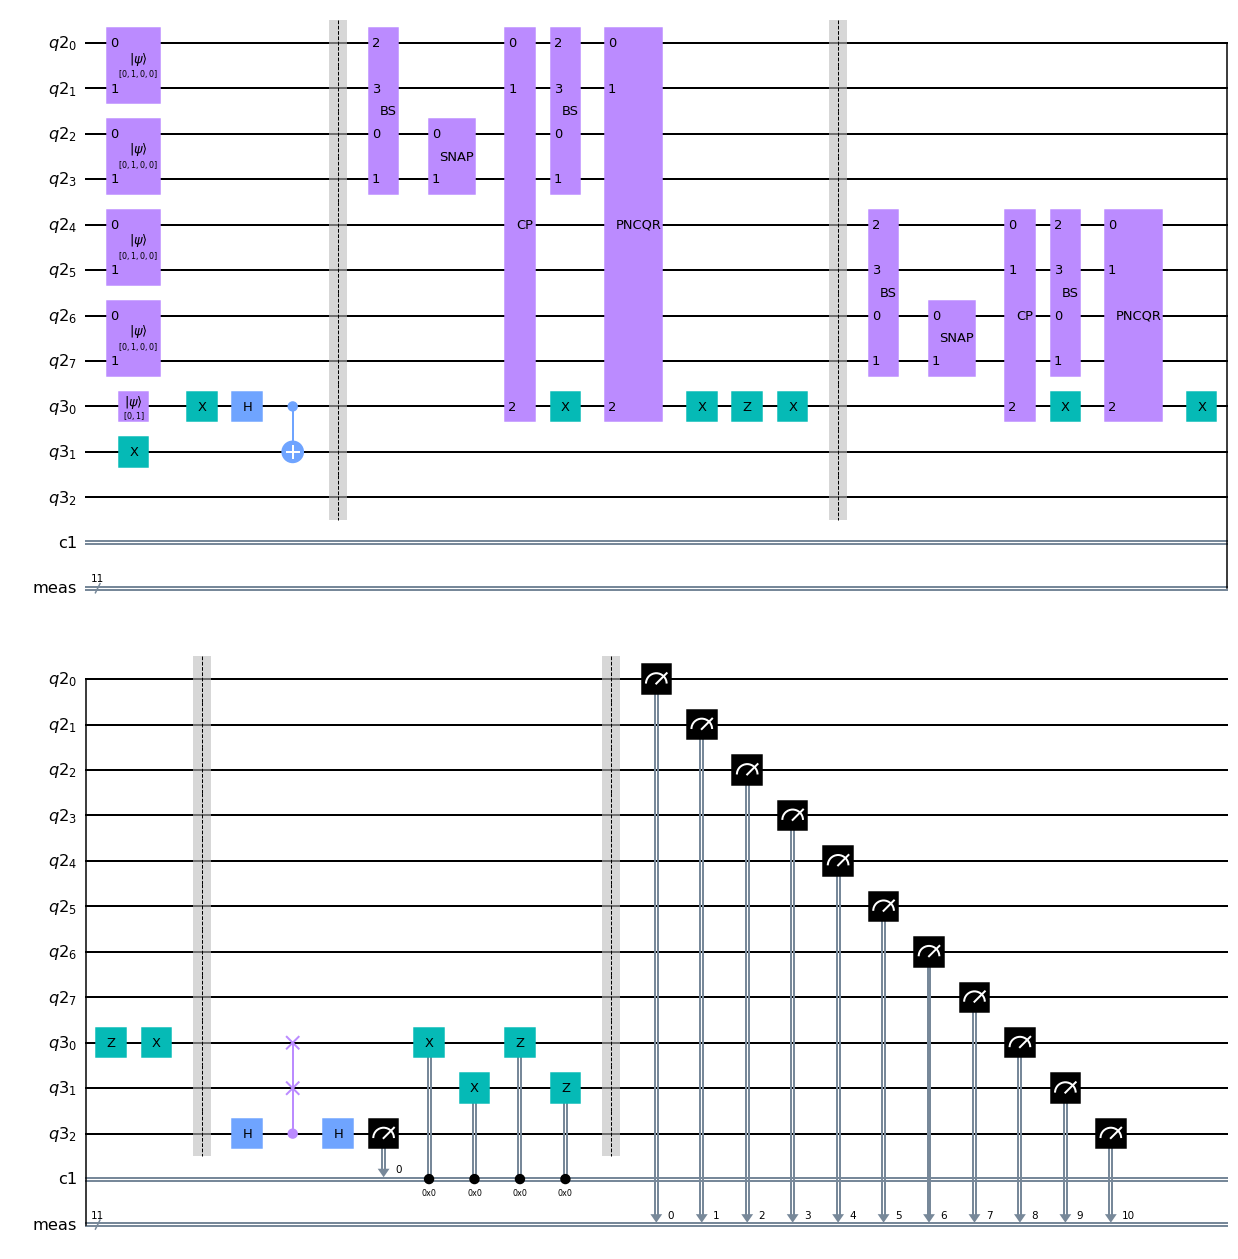

In [11]:
circuit.draw(output='mpl', filename='aklt_circuit.png')

# Simulate the circuit

### Simulate locally with Qiskit Aer and print state

In [8]:
# When run enough times the state of the qubits changes because the measurement collapses the state of the memory qubits
# stateop, _ = c2qa.util.simulate(circuit)
stateop, result = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())

qubits:  000  qumodes:  21     with amplitude:  1.0
Counts(ideal): {'0110010 0': 348, '0111001 0': 163, '0001001 0': 167, '0000100 0': 346}


### Send to IBM Matrix Product State simulator (free to access)

##### Configure IBMQ account (only needs to be run once)

In [19]:
## Configure session to run on your IBMQ account (free to create). Only needs to be run once
# IBMQ.save_account('74e12532dbce8c34a6e9c9a058822a5ef6a56142c323c9d964837b4ffee47408a560b45350eef82fb5dc061ba6dd818c2bbc6a884316a98947914b4161b08afb')

##### Load IBMQ account and choose the backend

In [18]:
print(IBMQ.load_account())
provider = IBMQ.get_provider()
# print(provider)
# backend = provider.get_backend('simulator_statevector')
backend = provider.get_backend('simulator_mps')
print("Backend: ",backend)

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>
Backend:  simulator_mps


##### Submit job

In [19]:
circuit_sys = transpile(circuit, backend)
shnb=8190
job = backend.run(circuit_sys, shots=shnb, job_name="AKLT1_MPS_"+str(numberofmodes)+"modes_"+str(shnb)+"shots")

##### Retreive job results

In [20]:
# Check online on IBMQ to find the job ID
job = backend.retrieve_job('61fa611d3cfe10cddf276ca3')
res = job.result()
counts = res.get_counts()
print("counts ", counts)

counts  {'000100000100101010101011000 0': 40, '000100000100101010110000101 0': 50, '000100000100101100000101000 0': 173, '000100000100101100001010101 0': 37, '000100000101000001001011000 0': 195, '000100000101000001010000101 0': 177, '000100000101000010100101000 0': 190, '000100000101000010101010101 0': 43, '000100001010010010101011000 0': 41, '000100001010010010110000101 0': 34, '000100001010010100000101000 0': 171, '000100001010010100001010101 0': 43, '000100001010101001001011000 0': 38, '000100001010101001010000101 0': 44, '000100001010101010100101000 0': 44, '000100001010101010101010101 0': 9, '001001001010101010101011000 0': 2, '001001001010101010110000101 0': 7, '001001001010101100000101000 0': 22, '001001001010101100001010101 0': 3, '001001001011000001001011000 0': 25, '001001001011000001010000101 0': 24, '001001001011000010100101000 0': 24, '001001001011000010101010101 0': 5, '001001010000010010101011000 0': 23, '001001010000010010110000101 0': 32, '001001010000010100000101000 

In [21]:
Nsites=7
dict0=stateReadout.changeBasis(counts, Nsites, splitup=1)
tripletdict=dict0[0]
weights=list(tripletdict.values())
chain=list(tripletdict.keys())
print("chain, weights ",chain, weights)
print("dict0[2]", dict0[2])
tripletcounts=list(dict0[2].values())[1]
print(tripletcounts)
stateReadout.stringoperator(chain,weights,tripletcounts)
for d in range(2,Nsites):
    stateReadout.stringoperator_variable(chain,weights,tripletcounts,d)

chain, weights  ['+-+-+-0', '+-+-+0-', '+-+-0+-', '+-+-000', '+-+0-+-', '+-+0-00', '+-+00-0', '+-+000-', '+-0+-+-', '+-0+-00', '+-0+0-0', '+-0+00-', '+-00+-0', '+-00+0-', '+-000+-', '+-00000', '+0-+-+-', '+0-+-00', '+0-+0-0', '+0-+00-', '+0-0+-0', '+0-0+0-', '+0-00+-', '+0-0000', '+00-+-0', '+00-+0-', '+00-0+-', '+00-000', '+000-+-', '+000-00', '+0000-0', '+00000-', '-+-+-+0', '-+-+-0+', '-+-+0-+', '-+-+000', '-+-0+-+', '-+-0+00', '-+-00+0', '-+-000+', '-+0-+-+', '-+0-+00', '-+0-0+0', '-+0-00+', '-+00-+0', '-+00-0+', '-+000-+', '-+00000', '-0+-+-+', '-0+-+00', '-0+-0+0', '-0+-00+', '-0+0-+0', '-0+0-0+', '-0+00-+', '-0+0000', '-00+-+0', '-00+-0+', '-00+0-+', '-00+000', '-000+-+', '-000+00', '-0000+0', '-00000+', '0+-+-+-', '0+-+-00', '0+-+0-0', '0+-+00-', '0+-0+-0', '0+-0+0-', '0+-00+-', '0+-0000', '0+0-+-0', '0+0-+0-', '0+0-0+-', '0+0-000', '0+00-+-', '0+00-00', '0+000-0', '0+0000-', '0-+-+-+', '0-+-+00', '0-+-0+0', '0-+-00+', '0-+0-+0', '0-+0-0+', '0-+00-+', '0-+0000', '0-0+-+0', '0-0

/tmp/ipykernel_4329/3745968163.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  print(plt.show())


None


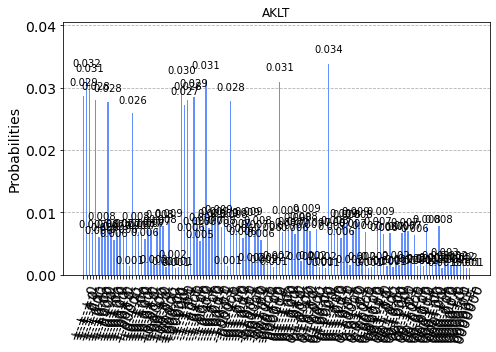

In [22]:
dict=stateReadout.makedictionnary(chain, weights)
plt=plot_histogram(dict, title='AKLT')
plt.tight_layout()
print(plt.show())

### Example of previous job

##### Retreive job results for a job with 12 modes = 7 sites (counting the memory qubit sites)

In [4]:
# Check online on IBMQ to find the job ID 61f98c729b08ec782fd3e2cd
job = backend.retrieve_job('6194efef711007b0af0d0814')
res = job.result()
counts = res.get_counts()
print("counts ", counts)

counts  {'000100000100101010101011000 0': 40, '000100000100101010110000101 0': 38, '000100000100101100000101000 0': 166, '000100000100101100001010101 0': 35, '000100000101000001001011000 0': 171, '000100000101000001010000101 0': 174, '000100000101000010100101000 0': 191, '000100000101000010101010101 0': 45, '000100001010010010101011000 0': 54, '000100001010010010110000101 0': 40, '000100001010010100000101000 0': 169, '000100001010010100001010101 0': 42, '000100001010101001001011000 0': 40, '000100001010101001010000101 0': 44, '000100001010101010100101000 0': 31, '000100001010101010101010101 0': 14, '001001001010101010101011000 0': 5, '001001001010101010110000101 0': 6, '001001001010101100000101000 0': 27, '001001001010101100001010101 0': 3, '001001001011000001001011000 0': 26, '001001001011000001010000101 0': 21, '001001001011000010100101000 0': 25, '001001001011000010101010101 0': 4, '001001010000010010101011000 0': 22, '001001010000010010110000101 0': 21, '001001010000010100000101000

In [5]:
Nsites=7
dict0=stateReadout.changeBasis(counts, Nsites, splitup=1)
tripletdict=dict0[0]
weights=list(tripletdict.values())
chain=list(tripletdict.keys())
print("chain, weights ",chain, weights)
print("dict0[2]", dict0[2])
tripletcounts=list(dict0[2].values())[1]
print(tripletcounts)
stateReadout.stringoperator(chain,weights,tripletcounts)
for d in range(2,Nsites):
    stateReadout.stringoperator_variable(chain,weights,tripletcounts,d)

chain, weights  ['+-+-+-0', '+-+-+0-', '+-+-0+-', '+-+-000', '+-+0-+-', '+-+0-00', '+-+00-0', '+-+000-', '+-0+-+-', '+-0+-00', '+-0+0-0', '+-0+00-', '+-00+-0', '+-00+0-', '+-000+-', '+-00000', '+0-+-+-', '+0-+-00', '+0-+0-0', '+0-+00-', '+0-0+-0', '+0-0+0-', '+0-00+-', '+0-0000', '+00-+-0', '+00-+0-', '+00-0+-', '+00-000', '+000-+-', '+000-00', '+0000-0', '+00000-', '-+-+-+0', '-+-+-0+', '-+-+0-+', '-+-+000', '-+-0+-+', '-+-0+00', '-+-00+0', '-+-000+', '-+0-+-+', '-+0-+00', '-+0-0+0', '-+0-00+', '-+00-+0', '-+00-0+', '-+000-+', '-+00000', '-0+-+-+', '-0+-+00', '-0+-0+0', '-0+-00+', '-0+0-+0', '-0+0-0+', '-0+00-+', '-0+0000', '-00+-+0', '-00+-0+', '-00+0-+', '-00+000', '-000+-+', '-000+00', '-0000+0', '-00000+', '0+-+-+-', '0+-+-00', '0+-+0-0', '0+-+00-', '0+-0+-0', '0+-0+0-', '0+-00+-', '0+-0000', '0+0-+-0', '0+0-+0-', '0+0-0+-', '0+0-000', '0+00-+-', '0+00-00', '0+000-0', '0+0000-', '0-+-+-+', '0-+-+00', '0-+-0+0', '0-+-00+', '0-+0-+0', '0-+0-0+', '0-+00-+', '0-+0000', '0-0+-+0', '0-0

/tmp/ipykernel_22316/3471893898.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  print(plt.show())


None


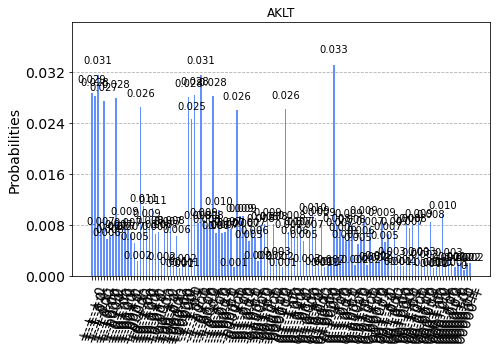

In [6]:
dict=stateReadout.makedictionnary(chain, weights)
plt=plot_histogram(dict, title='AKLT')
plt.tight_layout()
print(plt.show())

In [ ]:
# job = backend.retrieve_job('61965390986f75d5ad6f1cf8')
# res = job.result()
# counts1 = res.get_counts()
#
# job = backend.retrieve_job('61965385acd92383f8e5a4d9')
# res = job.result()
# counts2 = res.get_counts()
#
# job = backend.retrieve_job('61965378986f7558d26f1cf7')
# res = job.result()
# counts3 = res.get_counts()
#
# job = backend.retrieve_job('6196536c7110076fdf0d0f9f')
# res = job.result()
# counts4 = res.get_counts()
#
# job = backend.retrieve_job('6196535971100738c50d0f9d')
# res = job.result()
# counts5 = res.get_counts()
#
#
# Cdict = Counter(counts1) + Counter(counts2) + Counter(counts3) + Counter(counts4) + Counter(counts5)
# print(Cdict)
# newList = [x / 5 for x in list(Cdict.values())]
# newdict=stateReadout.makedictionnary(Cdict.keys(), newList)
# print("newdict ",newdict)
#
# dict0=stateReadout.changeBasis(newdict, 5, splitup=1)
# tripletdict=dict0[0]
# weights=list(tripletdict.values())
# chain=list(tripletdict.keys())
# print("chain, weights ",chain, weights)
# print("dict0[2]", dict0[2])
# tripletcounts=list(dict0[2].values())[1]
# print(tripletcounts)
# stateReadout.stringoperator(chain,weights,tripletcounts)
# for d in range(2,5):
#     stateReadout.stringoperator_variable(chain,weights,tripletcounts,d)